# EDA | Problem exploration
---
---

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../../")
import pickle

#### Third party imports

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Extracting data

## 2022-2023 Dataset

In [4]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [5]:
dfx

,appointment_id,appointment_weekday,appointment_start,appointment_dur_min,recurring_patient,creation_to_start_hrs,confirm_request_msg,patient_confirm,confirm_to_start_hrs,clinic,appointment_source,appointment_date_update,patient_age,patient_sex,doctor,medical_specialty,appointment_status_simplified
0,2022524854,0,2022-07-04 15:00:00,30.0,NaN,NaN,0,0,NaN,TLALPAN,phone,no_update,NaN,None,DR. AQUILES RUBIO BLANCAS,NUTRICION,unused
1,2022524855,0,2022-07-04 16:30:00,30.0,NaN,NaN,0,0,NaN,TLALPAN,phone,no_update,NaN,None,DR. AQUILES RUBIO BLANCAS,NUTRICION,unused
2,2021923564,5,2022-01-22 12:30:00,30.0,first,20.52,0,0,NaN,MARINA NACIONAL,phone,no_update,32.0,F,DR. ORLANDO JOSE HERNANDEZ MARTINEZ,UROLOGIA,cancel_employee
3,2021853399,0,2022-01-24 12:00:00,30.0,first,52.19,0,0,NaN,MARINA NACIONAL,phone,no_update,32.0,F,DRA JUANA GUADALUPE CABALLERO MARTINEZ,GINECOLOGIA,cancel_employee
4,2021845947,0,2022-01-31 13:00:00,30.0,first,221.78,0,0,NaN,TLALPAN,phone,no_update,32.0,F,Mariana Sarao Pineda,DERMATOLOGIA,cancel_patient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544083,2022136584,3,2022-12-29 10:00:00,30.0,recurrent,2181.63,1,1,49.28,COAPA,phone,no_update,60.0,M,DRA LAURA FABIOLA PORTILLO GARCIA,NEFROLOGIA,no_show
544084,2022141229,2,2022-11-30 08:30:00,30.0,recurrent,14.12,0,1,14.05,COAPA,phone,no_update,33.0,M,DR. MIGUEL ANGEL MONTERO MARQUEZ,OTORRINOLARINGOLOGIA,completed
544085,2022506277,5,2022-06-25 10:00:00,30.0,first,25.08,0,1,19.02,COAPA,phone,no_update,33.0,M,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,completed
544086,2023228381,3,2023-01-05 08:30:00,30.0,recurrent,39.87,0,1,15.32,COAPA,phone,no_update,33.0,M,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,no_show


## Query

In [35]:
## Function parameters
db_crds = 'pc_db_prod'
sql_files_path = '../../pkg_dir/sql/'
sql_script = 'appointments.sql'
sql_params = sql_params_appointments

In [36]:
dfx = sql_to_df(db_crds, sql_files_path, sql_script, sql_params)

In [37]:
## Reference to simplify labels in appointment status
values_map = {
    
    'COMPLETADA': 'completed',
    'SALA_ESPERA': 'completed',
    'CONSULTA': 'completed',
    'CONFIRMADO_PAGO': 'completed',

    'NO_PRESENTO': 'no_show',
    'MENSAJE_DEJADO': 'no_show',
    'NO_CONFIRMADO': 'no_show',
    'CONFIRMADO': 'no_show',
    'LLEGA_TARDE_ESPERA': 'no_show',
    'REAGENDAR': 'no_show',
    
}

In [38]:
## Mapping values according to reference
dfx['appointment_status_simple'] = dfx['appointment_status'].map(values_map).fillna(dfx['appointment_status'])

In [41]:
## Formatting appointment date
dfx['appointment_date'] = pd.to_datetime(dfx['appointment_date'])

# Solving questions

---
### What was the no-show rate in 2023?

##### 
##### Using query

In [22]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [25]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

In [14]:
dfx['appointment_status_simple'].value_counts()

appointment_status_simple
completed    138186
no_show       25380
Name: count, dtype: int64

In [15]:
dfx['appointment_status_simple'].value_counts(normalize=True)

appointment_status_simple
completed    0.844833
no_show      0.155167
Name: proportion, dtype: float64

##### 
##### Using 2022-2023 dataset

In [40]:
# mr1 = dfx['appointment_status_simplified'].isin(['unused', 'completed', 'no_show'])
mr1 = dfx['appointment_status_simplified'].isin(['completed', 'no_show'])
mr2 = dfx['appointment_date'].dt.year == 2023
mrs = mr1 & mr2

rc = ['appointment_status_simplified', 'appointment_id']

In [41]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts()

appointment_status_simplified
completed    138654
no_show       25652
Name: count, dtype: int64

In [42]:
dfx.loc[mrs, 'appointment_status_simplified'].value_counts(normalize=True)

appointment_status_simplified
completed    0.843877
no_show      0.156123
Name: proportion, dtype: float64

---
### What was the last status of the confirmed appointments?

In [80]:
sql_string = """
SELECT
       cita.citaid as appointment_id,
       c.cestatusobs

FROM cita

         INNER JOIN citaestatus c ON cita.citaid = c.citaid AND cita.citaanio = c.citaanio


WHERE citafecha >= '2023-01-01'
  AND citafecha <= '2023-12-31'
  AND c.cestatusobs ~ ':(.*)Confirmado'
  AND citaestado in (
      'NO_PRESENTO',
        'MENSAJE_DEJADO',
        'NO_CONFIRMADO',
        'CONFIRMADO',
        'REAGENDAR',
  )
  
;
"""

In [81]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
        1: "appt_status",
    }, 
    inplace=True
)

In [86]:
## Removing duplicates
dfx = dfx.loc[~dfx[['appointment_id']].duplicated(keep='first'), :]

---
### No-show rate in 2023 segmented per clinic

##### 
##### With final dataset

In [290]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [291]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [292]:
dfy = dfy.pivot(
    index=['appointment_date', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [293]:
dfy.fillna(0, inplace=True)

In [294]:
dfy['appts'] = dfy['completed'] + dfy['no_show']
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']

In [295]:
dfy['ns/appt'] = dfy['no_show']/(dfy['appts'])
dfy['ns/total'] = dfy['no_show']/dfy['total']

In [296]:
dfy

,appointment_date,clinic,completed,no_show,unused,appts,total,ns/appt,ns/total
0,2023-12-31,BASILICA,32891,7121,7782,40012,47794,0.177972,0.148994
1,2023-12-31,COAPA,28282,4522,7901,32804,40705,0.137849,0.111092
2,2023-12-31,CUAJIMALPA,11590,1721,11200,13311,24511,0.129292,0.070213
3,2023-12-31,DEL VALLE,4719,992,3543,5711,9254,0.173700,0.107197
4,2023-12-31,DOCTORES,1770,373,2826,2143,4969,0.174055,0.075065
5,2023-12-31,MARINA NACIONAL,14929,2715,5889,17644,23533,0.153877,0.115370
6,2023-12-31,MONTEVIDEO,6893,1037,7344,7930,15274,0.130769,0.067893
7,2023-12-31,TLALPAN,22066,4207,9368,26273,35641,0.160126,0.118038


##### 
##### Original calculation

In [158]:
## Grouping data by clinic
dfy = dfx.loc[:, ['appointment_id', 'appointment_status_simple', 'clinic']].groupby(
    [
        'clinic',
        'appointment_status_simple',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [159]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['count']/dfy.groupby(["clinic"])["count"].transform("sum")

In [160]:
dfy

count  proportion
clinic          appointment_status_simple                   
BASILICA        completed                  36186    0.821905
                no_show                     7841    0.178095
COAPA           completed                  31480    0.865929
                no_show                     4874    0.134071
CUAJIMALPA      completed                  12510    0.870200
                no_show                     1866    0.129800
DEL VALLE       completed                   5505    0.827820
                no_show                     1145    0.172180
DOCTORES        completed                   2170    0.826982
                no_show                      454    0.173018
MARINA NACIONAL completed                  17939    0.845980
                no_show                     3266    0.154020
MONTEVIDEO      completed                   8182    0.867564
                no_show                     1249    0.132436
TLALPAN         completed                  24214    0.837884
                no_show                     4685    0.162116

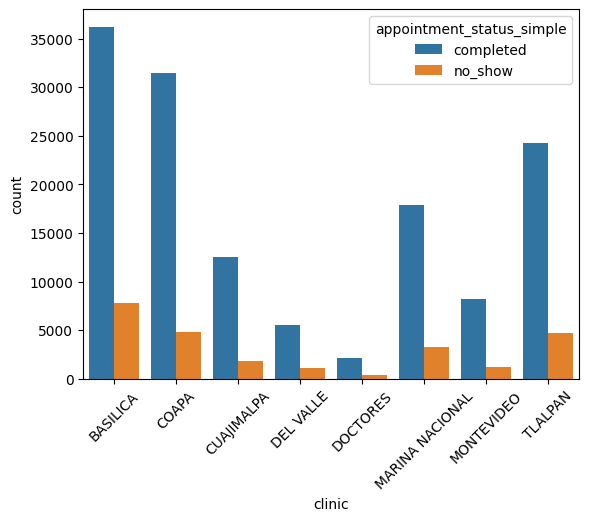

In [154]:
plt = sns.barplot(
    dfy, 
    x="clinic", 
    y="count", 
    hue="appointment_status_simple", 
    )

for item in plt.get_xticklabels():
    item.set_rotation(45)

---
### Evolution of no shows in clinics

In [238]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [239]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='QS'),
        'clinic',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

In [240]:
dfy = dfy.pivot(
    index=['appointment_date', 'clinic'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [241]:
dfy.fillna(0, inplace=True)

In [242]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']

In [243]:
dfy['ns_ratio'] = dfy['no_show']/dfy['completed']

In [244]:
dfy

,appointment_date,clinic,completed,no_show,unused,total,ns_ratio
0,2022-01-01,BASILICA,6112.0,2032.0,3051.0,11195.0,0.332461
1,2022-01-01,COAPA,6448.0,2433.0,2003.0,10884.0,0.377326
2,2022-01-01,MARINA NACIONAL,3148.0,963.0,1008.0,5119.0,0.305909
3,2022-01-01,MONTEVIDEO,748.0,143.0,1789.0,2680.0,0.191176
4,2022-01-01,TLALPAN,4417.0,1691.0,2532.0,8640.0,0.382839
5,2022-04-01,BASILICA,6637.0,1629.0,3078.0,11344.0,0.245442
6,2022-04-01,COAPA,6311.0,1955.0,3281.0,11547.0,0.309777
7,2022-04-01,CUAJIMALPA,373.0,53.0,1921.0,2347.0,0.142091
8,2022-04-01,MARINA NACIONAL,3469.0,957.0,1034.0,5460.0,0.275872
9,2022-04-01,MONTEVIDEO,896.0,138.0,1375.0,2409.0,0.154018


<Axes: xlabel='appointment_date', ylabel='ns_ratio'>

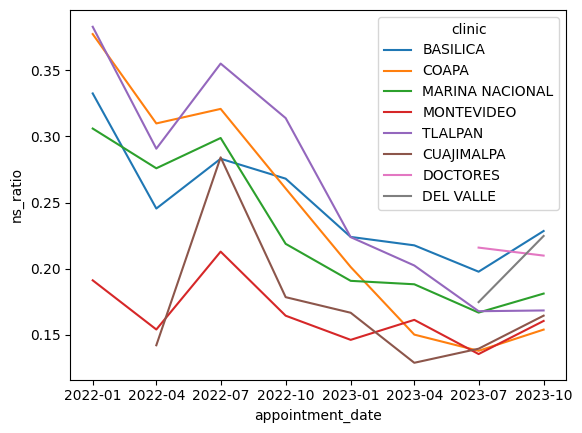

In [248]:
sns.lineplot(
    x="appointment_date", 
    y="ns_ratio",
    hue="clinic",
    data=dfy,
    markers=True
)

---
### How many historic data points we have of appointments?

In [27]:
sql_string = """
SELECT DATE_PART('year', citafecha) as appointment_year,
       COUNT(*) as entry_count

FROM cita

INNER JOIN sucursal ON cita.citasucursalid = sucursal.sucursalid
INNER JOIN citaestatus c ON cita.citaid = c.citaid AND cita.citaanio = c.citaanio

WHERE citafecha >= '2000-11-03'
  AND citafecha < '2024-01-01'
  AND c.cestatusobs ~* '\yCreado\y'
  AND citaestado IN (
                         'DISPONIBLE',
                         'NO_PRESENTO',
                         'COMPLETADA'
                        )

GROUP BY appointment_year

;"""

In [29]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "year",
        1: "count",
    }, 
    inplace=True
)

In [31]:
dfx

,year,count
0,2021.0,87039
1,2022.0,117323
2,2023.0,146176


---
### Average number of appointments per speciality

In [486]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.year == 2023
mr3 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA'
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [487]:
dfy = dfx.loc[mrs, rc].copy()

In [485]:
dfy = dfy.groupby(
    [
        'appointment_date',
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

,appointment_date,medical_specialty,appointment_status_simplified,appointment_id
0,2023-01-02,DERMATOLOGIA,completed,26
1,2023-01-02,DERMATOLOGIA,no_show,10
2,2023-01-02,DERMATOLOGIA,unused,1
3,2023-01-02,ENDOCRINOLOGIA,completed,8
4,2023-01-02,ENDOCRINOLOGIA,no_show,2
...,...,...,...,...
6714,2023-12-29,REUMATOLOGIA,completed,8
6715,2023-12-29,REUMATOLOGIA,unused,4
6716,2023-12-29,ULTRASONIDO,completed,10
6717,2023-12-29,ULTRASONIDO,no_show,1


In [449]:
dfy = dfy.pivot(
    index=['appointment_date', 'medical_specialty'], 
    columns=['appointment_status_simplified'], 
    values=['appointment_id'], 
).reset_index()

dfy.columns = [
    col[1] 
    if col[0] == 'appointment_id'
    else col[0]
    for col in dfy.columns
]

In [450]:
## 
dfy.fillna(0, inplace=True)

In [451]:
dfy['total'] = dfy['completed'] + dfy['no_show'] + dfy['unused']

In [452]:
dfy['ns_ratio'] = dfy['no_show']/dfy['total']

In [453]:
dfy

,appointment_date,medical_specialty,completed,no_show,unused,total,ns_ratio
0,2023-01-02,DERMATOLOGIA,26.0,10.0,1.0,37.0,0.270270
1,2023-01-02,ENDOCRINOLOGIA,8.0,2.0,2.0,12.0,0.166667
2,2023-01-02,GASTROENTEROLOGIA,8.0,3.0,0.0,11.0,0.272727
3,2023-01-02,GINECOLOGIA,15.0,4.0,2.0,21.0,0.190476
4,2023-01-02,NEUROLOGIA,6.0,2.0,4.0,12.0,0.166667
...,...,...,...,...,...,...,...
2722,2023-12-29,NEUROLOGIA,6.0,4.0,2.0,12.0,0.333333
2723,2023-12-29,OTORRINOLARINGOLOGIA,0.0,1.0,0.0,1.0,1.000000
2724,2023-12-29,REUMATOLOGIA,8.0,0.0,4.0,12.0,0.000000
2725,2023-12-29,ULTRASONIDO,10.0,1.0,0.0,11.0,0.090909


In [454]:
dfy2 = dfy.groupby(
    [
        'medical_specialty',
    ]
).agg(
    {
        'completed': 'mean',
        'no_show': 'mean',
        'unused': 'mean',
        'total': ['mean', 'sum'],
        'appointment_date': 'nunique',
    }
)

# dfy2.columns = [col[0] + '_$' + col[1] for col in dfy2.columns]

dfy2.sort_values(by=('total', 'sum'), inplace=True, ascending=False)

dfy2

completed   no_show    unused      total           \
                           mean      mean      mean       mean      sum   
medical_specialty                                                         
DERMATOLOGIA          36.238462  8.453846  4.184615  48.876923  12708.0   
GINECOLOGIA           17.725869  4.150579  4.563707  26.440154   6848.0   
UROLOGIA              12.609375  2.375000  5.050781  20.035156   5129.0   
OTORRINOLARINGOLOGIA  11.858824  3.027451  1.309804  16.196078   4130.0   
ULTRASONIDO            9.148000  1.436000  2.992000  13.576000   3394.0   
NEUROLOGIA             8.297297  1.401544  2.096525  11.795367   3055.0   
GASTROENTEROLOGIA      8.890909  1.772727  1.140909  11.804545   2597.0   
ENDOCRINOLOGIA         8.031390  1.825112  0.883408  10.739910   2395.0   
REUMATOLOGIA           8.171053  1.315789  2.427632  11.914474   1811.0   
NEUMOLOGIA             7.180645  1.438710  2.225806  10.845161   1681.0   
NUTRICION              2.462500  0.806250  5.068750   8.337500   1334.0   
PROCTOLOGIA            5.641975  1.617284  1.604938   8.864198    718.0   
ORTOPEDIA              4.819444  1.250000  3.166667   9.236111    665.0   
ANGIOLOGIA             8.291667  1.625000  0.895833  10.812500    519.0   
NEFROLOGIA             7.625000  1.650000  1.100000  10.375000    415.0   
Ultrasonido            5.666667  0.476190  4.619048  10.761905    226.0   
OFTALMOLOGIA          12.000000  4.000000  5.333333  21.333333     64.0   
MEDICINA GENERAL+IA    2.000000  0.777778  3.666667   6.444444     58.0   
ALERGOLOGIA            3.500000  0.750000  7.500000  11.750000     47.0   

                     appointment_date  
                              nunique  
medical_specialty                      
DERMATOLOGIA                      260  
GINECOLOGIA                       259  
UROLOGIA                          256  
OTORRINOLARINGOLOGIA              255  
ULTRASONIDO                       250  
NEUROLOGIA                        259  
GASTROENTEROLOGIA                 220  
ENDOCRINOLOGIA                    223  
REUMATOLOGIA                      152  
NEUMOLOGIA                        155  
NUTRICION                         160  
PROCTOLOGIA                        81  
ORTOPEDIA                          72  
ANGIOLOGIA                         48  
NEFROLOGIA                         40  
Ultrasonido                        21  
OFTALMOLOGIA                        3  
MEDICINA GENERAL+IA                 9  
ALERGOLOGIA                         4

In [170]:
dfy2 = dfy.groupby(
    [
        'medical_specialty',
    ]
).agg(
    {
        'completed': 'mean',
        'no_show': 'mean',
        'unused': 'mean',
        'total': ['mean', 'sum'],
        'appointment_date': 'nunique',
    }
)

# dfy2.columns = [col[0] + '_$' + col[1] for col in dfy2.columns]

dfy2.sort_values(by=('total', 'sum'), inplace=True, ascending=False)

dfy2

completed   no_show    unused      total           \
                           mean      mean      mean       mean      sum   
medical_specialty                                                         
DERMATOLOGIA          36.238462  8.453846  4.184615  48.876923  12708.0   
GINECOLOGIA           17.725869  4.150579  4.563707  26.440154   6848.0   
UROLOGIA              12.609375  2.375000  5.050781  20.035156   5129.0   
OTORRINOLARINGOLOGIA  11.858824  3.027451  1.309804  16.196078   4130.0   
ULTRASONIDO            9.148000  1.436000  2.992000  13.576000   3394.0   
NEUROLOGIA             8.297297  1.401544  2.096525  11.795367   3055.0   
GASTROENTEROLOGIA      8.890909  1.772727  1.140909  11.804545   2597.0   
ENDOCRINOLOGIA         8.031390  1.825112  0.883408  10.739910   2395.0   
REUMATOLOGIA           8.171053  1.315789  2.427632  11.914474   1811.0   
NEUMOLOGIA             7.180645  1.438710  2.225806  10.845161   1681.0   
NUTRICION              2.462500  0.806250  5.068750   8.337500   1334.0   
PROCTOLOGIA            5.641975  1.617284  1.604938   8.864198    718.0   
ORTOPEDIA              4.819444  1.250000  3.166667   9.236111    665.0   
ANGIOLOGIA             8.291667  1.625000  0.895833  10.812500    519.0   
NEFROLOGIA             7.625000  1.650000  1.100000  10.375000    415.0   
Ultrasonido            5.666667  0.476190  4.619048  10.761905    226.0   
OFTALMOLOGIA          12.000000  4.000000  5.333333  21.333333     64.0   
MEDICINA GENERAL+IA    2.000000  0.777778  3.666667   6.444444     58.0   
ALERGOLOGIA            3.500000  0.750000  7.500000  11.750000     47.0   

                     appointment_date  
                              nunique  
medical_specialty                      
DERMATOLOGIA                      260  
GINECOLOGIA                       259  
UROLOGIA                          256  
OTORRINOLARINGOLOGIA              255  
ULTRASONIDO                       250  
NEUROLOGIA                        259  
GASTROENTEROLOGIA                 220  
ENDOCRINOLOGIA                    223  
REUMATOLOGIA                      152  
NEUMOLOGIA                        155  
NUTRICION                         160  
PROCTOLOGIA                        81  
ORTOPEDIA                          72  
ANGIOLOGIA                         48  
NEFROLOGIA                         40  
Ultrasonido                        21  
OFTALMOLOGIA                        3  
MEDICINA GENERAL+IA                 9  
ALERGOLOGIA                         4

In [123]:
dfy2 = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='m'),
        'medical_specialty',
    ]
).agg(
    {
        'completed': 'mean',
        'no_show': 'mean',
        'unused': 'mean',
    }
)

dfy2

completed   no_show    unused
appointment_date medical_specialty                                  
2023-01-31       DERMATOLOGIA          30.038462  7.500000  1.500000
                 ENDOCRINOLOGIA         8.466667  1.666667  0.400000
                 GASTROENTEROLOGIA      8.136364  1.954545  0.136364
                 GINECOLOGIA           14.960000  4.480000  1.040000
                 NEUMOLOGIA             7.750000  1.333333  2.083333
...                                          ...       ...       ...
2023-12-31       OTORRINOLARINGOLOGIA   8.809524  1.619048  0.571429
                 PROCTOLOGIA            4.000000  2.200000  0.200000
                 REUMATOLOGIA           7.200000  2.000000  2.800000
                 ULTRASONIDO            7.913043  1.739130  0.608696
                 UROLOGIA              10.095238  2.142857  2.952381

[184 rows x 3 columns]

---
### No shows per specialty in 2023

###### 
###### Old calculation

In [56]:
## Grouping data by clinic
dfy = dfx.groupby(
    [
        'medical_specialty',
        'appointment_status_simple',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count'
    }
)

## Renaming aggregate column
dfy.rename(columns={'appointment_id': 'count'}, inplace=True)

In [57]:
## Adding new column with proportions
dfy["proportion"] = dfy['count']/dfy.groupby(["medical_specialty"])["count"].transform("sum")

In [61]:
dfy.loc[dfy['appointment_status_simple'] == 'no_show', :].sort_values(by='proportion', ascending=False)

In [68]:
dfy

,medical_specialty,appointment_status_simple,count,proportion
1,ALERGOLOGIA,no_show,119,0.154145
3,ANGIOLOGIA,no_show,337,0.173087
5,CARDIOLOGIA,no_show,762,0.113579
7,DERMATOLOGIA,no_show,5584,0.181375
9,ENDOCRINOLOGIA,no_show,1645,0.146170
11,GASTROENTEROLOGIA,no_show,1934,0.144945
13,GERIATRIA,no_show,10,0.188679
15,GINECOLOGIA,no_show,4252,0.165835
17,MEDICINA GENERAL+IA,no_show,200,0.112045
19,MEDICINA INTERNA,no_show,231,0.116667


---
### How many of the no-shows are patients that were confirmed?

In [57]:
mr1 = dfy['appointment_status_simplified'] == 'no_show'
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__confirmed_$date',
]

In [73]:
dfy = dfx.loc[mrs, rc].copy()

In [75]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].fillna('not_confirmed')

In [76]:
dfy['meta__confirmed_$date'] = dfy['meta__confirmed_$date'].apply(lambda x: 'confirmed' if x != 'not_confirmed' else x)

In [80]:
dfy = dfy.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
        'meta__confirmed_$date',
    ]
).agg(
    'count'
)

dfy

appointment_id
appointment_date meta__confirmed_$date                
2022-12-31       confirmed                       19499
                 not_confirmed                   11677
2023-12-31       confirmed                       23762
                 not_confirmed                    1890

In [86]:
## Adding new column with proportions per clinic
dfy["proportion"] = dfy['appointment_id']/dfy.groupby(['appointment_date'])["appointment_id"].transform("sum")

In [87]:
dfy

appointment_id  proportion
appointment_date meta__confirmed_$date                            
2022-12-31       confirmed                       19499    0.625449
                 not_confirmed                   11677    0.374551
2023-12-31       confirmed                       23762    0.926322
                 not_confirmed                    1890    0.073678

---
### Appointments by channel

In [114]:
mr1 = dfx['meta__created_$user'].notnull()
mrs = mr1

rc = [
    'appointment_id',
    'appointment_date',
    'meta__created_$user',
    'appointment_status_simplified',
]

In [115]:
dfy = dfx.loc[mrs, rc].copy()

In [119]:
dfy['meta__created_$user'] = dfy['meta__created_$user'].apply(lambda x: 'online' if x == 'citas.online' else 'phone')

In [121]:
dfy['meta__created_$user'].value_counts()

meta__created_$user
phone     378146
online      2688
Name: count, dtype: int64

In [109]:
dfy[dfy['meta__created_$user'].str.contains('online')]

,appointment_id,appointment_date,meta__created_$user,appointment_status_simplified
137,2021828317,2022-01-12,citas.online,no_show
143,2021828343,2022-01-18,citas.online,no_show
149,2021828355,2022-01-19,citas.online,completed
388,2021829538,2022-01-28,citas.online,cancel_employee
516,2023136917,2023-11-03,citas.online,completed
...,...,...,...,...
543225,2023000645847,2023-11-11,citas.online,completed
543364,2021817596,2022-02-01,citas.online,cancel_employee
543372,2021817634,2022-01-19,citas.online,completed
543373,2021817641,2022-01-18,citas.online,completed


In [107]:
dfy['meta__created_$user'].unique()

array(['paris.padilla_call', 'katya.martinez', 'jessica.escamil',
       'veronica.anaya', 'valeria.flores', 'xaidani.contrer',
       'alejandra.sanch', 'brenda.delacruz', 'karina.carballo',
       'marisol.santiag', 'ivonne.gonzalez', 'veronica.anaya_bot',
       'rafael.luna_call', 'valeria.galvan', 'fernando.maya_call',
       'melina.moreno_bot', 'samantha', 'samantha.ortiz',
       'estrella.rivero_bot', 'ximena.juarez_call', 'zuleyma.flores',
       'adrian.herrera', 'mileidi.roman', 'brenda.delacruz_call',
       'yafte.trejo_call', 'gisela.garrido_call', 'adriana.sota',
       'yaselin', 'karla.gutierrez', 'araceli.gonzale', 'cristina.herrer',
       'jessica.salazar', 'veronica.vargas', 'gabriela.vargas',
       'santa.celes', 'brenda.aguirre', 'erika.cornejo', 'irlanda.garcia',
       'citas.online', 'anayeli.carav', 'cecilia.chaparro', 'rosalia',
       'elizabeth.muñoz', 'paola.mira', 'ana.barranco',
       'fryda.sternenfels', 'fabiola.morales_call', 'arely.lopez',
      

In [103]:
dfy[dfy['meta__created_$user'].str.contains('online')]['appointment_status_simplified'].value_counts()

appointment_status_simplified
completed          1169
cancel_employee    1156
no_show             207
cancel_patient      143
blocked              13
Name: count, dtype: int64

In [ ]:
dfy['meta__created_$user'].info()

In [ ]:
dfx

---
### Appointments with the largest lead time

---
### How do appointments behave per time of day?

##### 
##### All appointments

In [522]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [523]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [524]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [525]:
dfy.groupby(
    [
        # 'start_time',
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

/var/folders/0q/3y5dk4390kqc86qh28v817lw0000gn/T/ipykernel_91914/925844730.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfy.groupby(


,st_bins,appointment_id
0,"(0.0, 0.5]",0
1,"(0.5, 1.0]",0
2,"(1.0, 1.5]",0
3,"(1.5, 2.0]",0
4,"(2.0, 2.5]",0
5,"(2.5, 3.0]",2
6,"(3.0, 3.5]",2
7,"(3.5, 4.0]",1
8,"(4.0, 4.5]",1
9,"(4.5, 5.0]",1


<Axes: xlabel='start_time', ylabel='Count'>

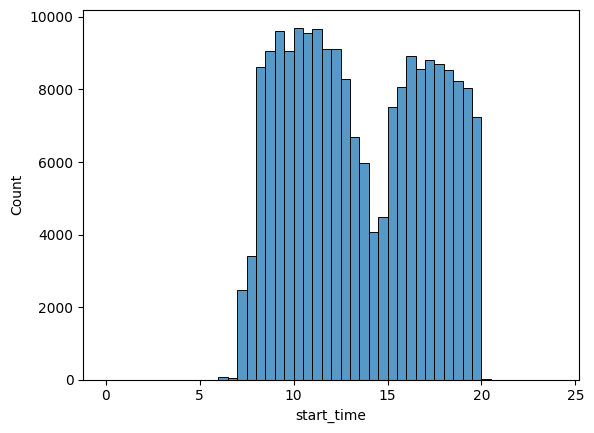

In [526]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

##### 
##### Separating by status

In [464]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [465]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [466]:
tr = 0.5
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [467]:
dfy.groupby(
    [
        'appointment_status_simplified',
        'st_bins',
    ],
    # as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

/var/folders/0q/3y5dk4390kqc86qh28v817lw0000gn/T/ipykernel_91914/1093728128.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfy.groupby(


appointment_id
appointment_status_simplified st_bins                     
completed                     (0.0, 0.5]                 0
                              (0.5, 1.0]                 0
                              (1.0, 1.5]                 0
                              (1.5, 2.0]                 0
                              (2.0, 2.5]                 0
...                                                    ...
unused                        (21.5, 22.0]               0
                              (22.0, 22.5]               0
                              (22.5, 23.0]               0
                              (23.0, 23.5]               0
                              (23.5, 24.0]               0

[144 rows x 1 columns]

<Axes: xlabel='start_time', ylabel='Count'>

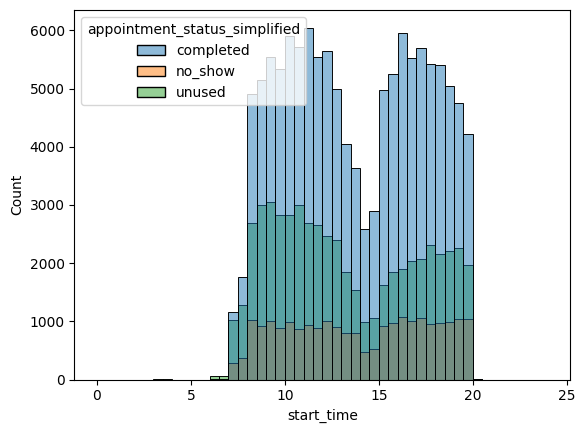

In [468]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
)

##### 
##### Focusing on clinic

In [461]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [462]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [424]:
tr = 1
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins)

In [425]:
dfy.groupby(
    [
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

/var/folders/0q/3y5dk4390kqc86qh28v817lw0000gn/T/ipykernel_91914/2681844464.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfy.groupby(


,st_bins,appointment_id
0,"(0, 1]",0
1,"(1, 2]",0
2,"(2, 3]",1
3,"(3, 4]",1
4,"(4, 5]",0
5,"(5, 6]",1
6,"(6, 7]",902
7,"(7, 8]",3342
8,"(8, 9]",4422
9,"(9, 10]",4642


<Axes: xlabel='start_time', ylabel='Count'>

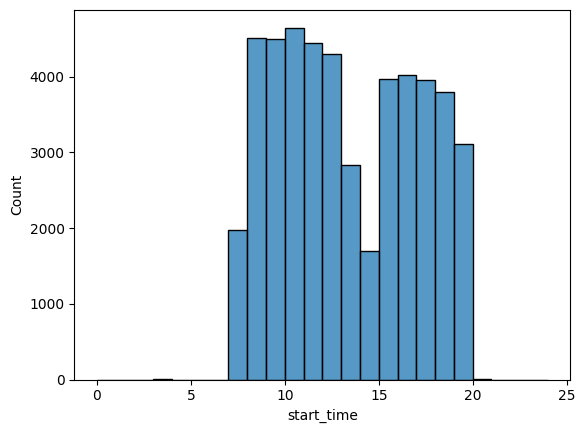

In [426]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

<Axes: xlabel='start_time', ylabel='Count'>

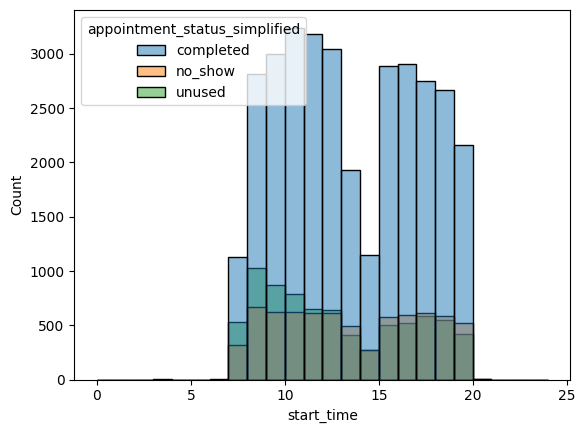

In [427]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
    hue='appointment_status_simplified',
    # title='Clinic: Basilica',
)

##### 
##### Focusing on clinic and specialty

In [544]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mr4 = dfx['clinic'] == 'BASILICA' 
mr5 = dfx['medical_specialty'] == 'DERMATOLOGIA'

# mrs = mr1 & mr2 & mr3 & mr4 & mr5
# mrs = mr1 & mr2 & mr4 & mr5
mrs = mr1 & mr4 & mr5

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_start_time',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [545]:
dfy['start_time'] = dfy['appointment_start_time'].str[:2].astype('float') + dfy['appointment_start_time'].str[-2:].astype('float')/60

In [546]:
tr = 1
bins = np.arange(0, 24 + tr, tr)
dfy['st_bins'] = pd.cut(dfy['start_time'], bins, right=False)

In [547]:
dfy.groupby(
    [
        'st_bins',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

/var/folders/0q/3y5dk4390kqc86qh28v817lw0000gn/T/ipykernel_91914/2681844464.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfy.groupby(


,st_bins,appointment_id
0,"[0, 1)",0
1,"[1, 2)",0
2,"[2, 3)",0
3,"[3, 4)",0
4,"[4, 5)",0
5,"[5, 6)",0
6,"[6, 7)",0
7,"[7, 8)",105
8,"[8, 9)",578
9,"[9, 10)",513


<Axes: xlabel='start_time', ylabel='Count'>

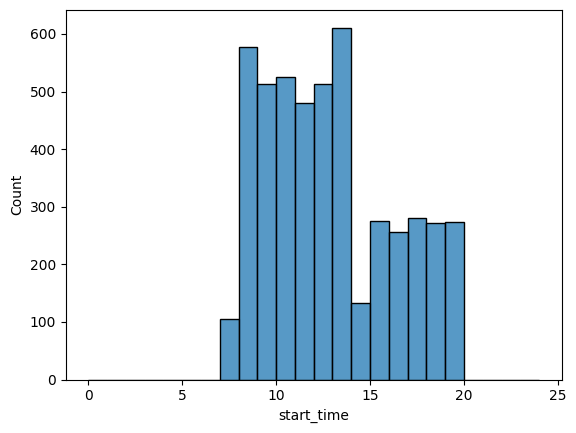

In [548]:
sns.histplot(
    data=dfy, 
    x="start_time",
    bins=bins,
)

---
### How do appointments behave per weekday?

In [476]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [477]:
dfy['weekday'] = dfy['appointment_date'].dt.weekday

In [478]:
dfy = dfy.groupby(
    [
        'weekday',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

<Axes: xlabel='weekday', ylabel='appointment_id'>

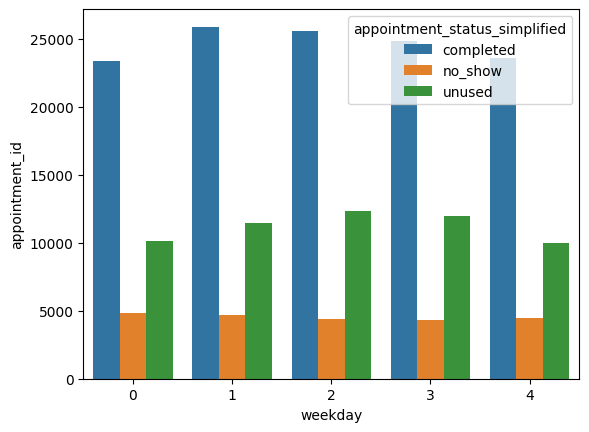

In [481]:
sns.barplot(
    data=dfy, 
    x="weekday",
    y="appointment_id",
    hue='appointment_status_simplified'
)

---
### What are the most popular times of day when appointments are scheduled

In [476]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'unused', 
        'completed', 
        'no_show', 
    ]
)
mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mr3 = dfx['appointment_date'].dt.year == 2023 ## only weekdays
mrs = mr1 & mr2 & mr3

rc = [
    'appointment_id',
    'appointment_date',
    'appointment_status_simplified',
]


dfy = dfx.loc[mrs, rc].copy()

In [477]:
dfy['weekday'] = dfy['appointment_date'].dt.weekday

---
### Exploring patients with location

---
### With how much time in advance are appointments confirmed?

In [4]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [5]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24*7
mr3 = dfx['confirm_to_start_hrs'] >= 0
mr4 = dfx['appointment_start'].dt.year == 2023
mrs = mr1 & mr2 & mr3 & mr4

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [6]:
dfy = dfx.loc[mrs, rc].copy()

<Axes: ylabel='Frequency'>

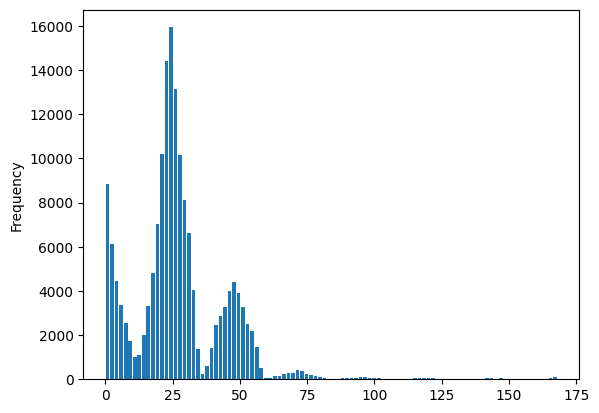

In [7]:
dfy['confirm_to_start_hrs'].plot(kind='hist', rwidth=0.8, bins=100)

---
### Confirmation time and cancellations
- When can we neglect cancellations as a label?

In [43]:
## Params
path = '../../pkg_dir/data/pickles/robs'
name = 'dataset_v1.pkl'


## Reading extract object saved as pickle locally
pkl_obj = path + "/" + name

with open(pkl_obj, 'rb') as obj_content:
    dfx = pickle.load(obj_content)

In [48]:
mr1 = dfx['confirm_to_start_hrs'].notnull()
mr2 = dfx['confirm_to_start_hrs'] <= 24
mrs = mr1 & mr2

rc = [
    'appointment_id',
    'appointment_start',
    'confirm_to_start_hrs',
    'appointment_status_simplified',
]

In [49]:
dfy = dfx.loc[mrs, rc].copy()

In [50]:
dfy['confirm_to_start_hrs'].describe()

count    131385.000000
mean         13.615165
std          41.030624
min      -10996.490000
25%           4.050000
50%          17.770000
75%          21.880000
max          24.000000
Name: confirm_to_start_hrs, dtype: float64

In [51]:
dfy.groupby(
    [
        pd.Grouper(key='appointment_start', freq='Y'),
        'appointment_status_simplified',
    ],
).agg(
    {
        'appointment_id': 'count',
    }
)

appointment_id
appointment_start appointment_status_simplified                
2022-12-31        cancel                                   2400
                  completed                               43620
                  no_show                                  7298
2023-12-31        cancel                                   4173
                  completed                               64025
                  no_show                                  9869

---
### What's the outcome of appointments that have a confirmation request message?

---
### xxx

---
### xxx

# Notes

### Duplicated values

In [111]:
dfx.loc[dfx[['appointment_id']].duplicated(keep=False), :].sort_values('appointment_id')

,appointment_id,appointment_date,appointment_start_time,appointment_end_time,appointment_creation,appointment_status,doctor,medical_specialty,clinic,patient_id,patient_birth_date,appointment_status_simple
123230,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
113004,2021170937,2023-10-11,11:00,11:30,16/08/2021 10:19:03,MENSAJE_DEJADO,DRA KARLA NOEMI SALAZAR VILLEGAS,DERMATOLOGIA,BASILICA,94937,1999-02-03,no_show
14162,2023000300922,2023-07-31,19:30,20:00,30/07/2023 09:02:21,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
14038,2023000300922,2023-07-31,19:30,20:00,27/07/2023 10:16:46,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,165429,1969-01-06,completed
141860,2023000300993,2023-09-18,16:30,17:00,16/09/2023 13:16:36,COMPLETADA,DRA SANDRA XOCHIQUETZAL CRUZ ORDOÑEZ,UROLOGIA,BASILICA,255714,1997-06-27,completed
...,...,...,...,...,...,...,...,...,...,...,...,...
56492,2023138378,2023-12-22,08:30,09:00,21/12/2023 12:01:29,COMPLETADA,DR. Hector Javier Sotelo Reyna,NEUMOLOGIA,BASILICA,282656,1990-03-08,completed
40371,2023144492,2023-12-22,12:00,12:30,17/12/2023 15:27:12,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
40518,2023144492,2023-12-22,12:00,12:30,21/12/2023 11:58:45,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,243929,1960-03-17,completed
119738,2023144498,2023-12-22,11:00,11:30,21/12/2023 11:57:58,COMPLETADA,DR. DANIEL GEOVANI VASQUEZ LOPEZ,REUMATOLOGIA,BASILICA,282769,1967-11-18,completed


### Executing custom query

In [22]:
sql_string = """
SELECT cita.citaid as appointment_id

FROM cita

WHERE citafecha >= '2000-11-03'
  AND citafecha <= '2021-01-01'

ORDER BY
    citafecha DESC

LIMIT 10

;
"""

In [25]:
dfx = sql_string_to_df(db_crds, sql_string)

dfx.rename(
    columns={
        0: "appointment_id",
    }, 
    inplace=True
)

### Number of total appointments

In [514]:
mr1 = dfx['appointment_status_simplified'].isin(
    [
        'completed', 
    ]
)
# mr2 = dfx['appointment_date'].dt.weekday < 5 ## only weekdays
mrs = mr1# & mr2

rc = [
    'appointment_id',
    'appointment_date',
    'clinic',
    'doctor',
    'medical_specialty',
    'appointment_status_simplified',
]

In [515]:
dfy = dfx.loc[mrs, rc].copy()

In [520]:
dfy2 = dfy.groupby(
    [
        # pd.Grouper(key='appointment_date', freq='W'),
        'appointment_date',
        'clinic',
    ],
    as_index=False
).agg(
    {
        'doctor': 'nunique'
    }
)

dfy2[-25:]

,appointment_date,clinic,doctor
3960,2023-12-28,COAPA,14
3961,2023-12-28,CUAJIMALPA,8
3962,2023-12-28,DEL VALLE,11
3963,2023-12-28,DOCTORES,6
3964,2023-12-28,MARINA NACIONAL,6
3965,2023-12-28,MONTEVIDEO,3
3966,2023-12-28,TLALPAN,10
3967,2023-12-29,BASILICA,8
3968,2023-12-29,COAPA,17
3969,2023-12-29,CUAJIMALPA,6


In [512]:
dfy2.groupby(
    [
        pd.Grouper(key='appointment_date', freq='Y'),
    ]
).agg(
    {
        'appointment_status_simplified': 'mean'
    }
)

,appointment_status_simplified
appointment_date,
2022-12-31,285.856354
2023-12-31,381.966942


In [485]:
dfy = dfy.groupby(
    [
        'appointment_date',
        'medical_specialty',
        'appointment_status_simplified',
    ],
    as_index=False
).agg(
    {
        'appointment_id': 'count',
    }
)

dfy

,appointment_date,medical_specialty,appointment_status_simplified,appointment_id
0,2023-01-02,DERMATOLOGIA,completed,26
1,2023-01-02,DERMATOLOGIA,no_show,10
2,2023-01-02,DERMATOLOGIA,unused,1
3,2023-01-02,ENDOCRINOLOGIA,completed,8
4,2023-01-02,ENDOCRINOLOGIA,no_show,2
...,...,...,...,...
6714,2023-12-29,REUMATOLOGIA,completed,8
6715,2023-12-29,REUMATOLOGIA,unused,4
6716,2023-12-29,ULTRASONIDO,completed,10
6717,2023-12-29,ULTRASONIDO,no_show,1


### xxx

---

---